In [ ]:
import pandas as pd
import numpy as np
from pandas_datareader import data as web

# Set parameters
start_date = '1963-01-01'
end_date = '2022-12-31'

# Load daily data that needs to be aggregated to monthly
daily_series = ["T10Y2Y", "T10Y3M", "NFCI", "DGS2", "DGS10"]
data_agg = web.DataReader(daily_series, "fred", start=start_date, end=end_date)
data_agg = data_agg.resample("M").mean()  # Resample to monthly using mean

# Load data that needs transforming
# Monthly growth rate data
monthly_growth_series = ["PAYEMS", "INDPRO", "RPI"]
data_mon_gr = web.DataReader(monthly_growth_series, "fred", start=start_date, end=end_date)
data_mon_gr = data_mon_gr.pct_change() * 100  # Convert to monthly percent change

# Annual growth rate data
annual_growth_series = ["UNRATE"]
data_a_gr = web.DataReader(annual_growth_series, "fred", start=start_date, end=end_date)
data_a_gr = data_a_gr.diff(12)  # 12-month difference to simulate annual growth rate

# Load other monthly data
other_monthly_series = ["USREC", "AAA", "BAA", "MCUMFN", "FEDFUNDS", "TB3MS"]
data_mon = web.DataReader(other_monthly_series, "fred", start=start_date, end=end_date)

# Join data on date
reg_data = data_agg.join([data_mon_gr, data_a_gr, data_mon], how="outer")

# Filter dates before 1960
reg_data = reg_data[reg_data.index >= "1960-01-01"]

# Additional transformations for model
# Corporate credit spread and yield spread
reg_data["corp_spread"] = reg_data["AAA"] - reg_data["BAA"]
reg_data["yld_spread"] = reg_data["DGS10"] - reg_data["TB3MS"]

# Define a function to calculate lags
def add_lags(df, columns, lags):
    for column in columns:
        for lag in lags:
            df[f"{column}_lag{lag}"] = df[column].shift(lag)
    return df

# Get lags of yld_spread and corporate spread
reg_data = add_lags(reg_data, ["yld_spread", "corp_spread"], [6, 12])

# Get lags of macroeconomic indicators
reg_data = add_lags(reg_data, ["INDPRO", "PAYEMS", "RPI", "UNRATE"], [1])

# Select final columns (exclude "date" as it's the index)
final_columns = ["USREC", "INDPRO", "PAYEMS", "RPI", "UNRATE", "corp_spread", "yld_spread",
                 "yld_spread_lag6", "yld_spread_lag12", "corp_spread_lag6", "corp_spread_lag12",
                 "INDPRO_lag1", "PAYEMS_lag1", "RPI_lag1", "UNRATE_lag1"]

# Filter the reg_data DataFrame to keep only the required columns
final_data = reg_data[final_columns]

# Reset the index and rename the date index column to "Date"
data = final_data.reset_index().rename(columns={'index': 'Date'})

# Save to CSV with "Date" as a column
data.to_csv("final_data.csv", index=False)


# # Save to CSV (index=True will use the date index in the CSV file)
# final_data.to_csv("final_data.csv", index=True)

print("Data saved as final_data.csv")



<ipython-input-1-9b7cbc45447e>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_agg = data_agg.resample("M").mean()  # Resample to monthly using mean


Data saved as final_data.csv


In [ ]:
print(data.describe())

                      DATE       USREC      INDPRO      PAYEMS         RPI  \
count                 1440  720.000000  719.000000  719.000000  719.000000   
mean   1992-12-30 10:15:00    0.118056    0.195124    0.142549    0.264890   
min    1963-01-01 00:00:00    0.000000  -13.241809  -13.570094  -13.433726   
25%    1977-12-31 18:00:00    0.000000   -0.171027    0.059185    0.055276   
50%    1992-12-31 12:00:00    0.000000    0.252848    0.163697    0.266832   
75%    2007-12-31 06:00:00    0.000000    0.632605    0.276644    0.471964   
max    2022-12-31 00:00:00    1.000000    6.584871    3.468882   20.174401   
std                    NaN    0.322898    0.947859    0.574626    1.260087   

           UNRATE  corp_spread  yld_spread  yld_spread_lag6  yld_spread_lag12  \
count  708.000000   720.000000         0.0              0.0               0.0   
mean    -0.034040    -1.020514         NaN              NaN               NaN   
min     -8.700000    -3.380000         NaN            

In [ ]:
# Print and check column names
print(data.columns)

Index(['DATE', 'USREC', 'INDPRO', 'PAYEMS', 'RPI', 'UNRATE', 'corp_spread',
       'yld_spread', 'yld_spread_lag6', 'yld_spread_lag12', 'corp_spread_lag6',
       'corp_spread_lag12', 'INDPRO_lag1', 'PAYEMS_lag1', 'RPI_lag1',
       'UNRATE_lag1'],
      dtype='object')


In [ ]:
data.head()

,DATE,USREC,INDPRO,PAYEMS,RPI,UNRATE,corp_spread,yld_spread,yld_spread_lag6,yld_spread_lag12,corp_spread_lag6,corp_spread_lag12,INDPRO_lag1,PAYEMS_lag1,RPI_lag1,UNRATE_lag1
0,1963-01-01,0.0,NaN,NaN,NaN,NaN,-0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1963-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1963-02-01,0.0,1.141512,0.204936,-0.527204,NaN,-0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1963-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.141512,0.204936,-0.527204,NaN
4,1963-03-01,0.0,0.615061,0.160057,0.452144,NaN,-0.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Check the size of the dataset (rows, columns)
print("Size of the dataset (rows, columns):", data.shape)

Size of the dataset (rows, columns): (1440, 16)


In [ ]:
null_counts = data.isnull().sum()
print("\nNumber of null values in each column:\n", null_counts)


Number of null values in each column:
 DATE                    0
USREC                 720
INDPRO                721
PAYEMS                721
RPI                   721
UNRATE                732
corp_spread           720
yld_spread           1440
yld_spread_lag6      1440
yld_spread_lag12     1440
corp_spread_lag6      723
corp_spread_lag12     726
INDPRO_lag1           721
PAYEMS_lag1           721
RPI_lag1              721
UNRATE_lag1           732
dtype: int64


In [ ]:
# Drop rows where 'USREC' is null
data = data.dropna(subset=['USREC'])

# Check the size of the cleaned dataset
print("Size of the dataset after dropping rows with null 'USREC' values (rows, columns):", data.shape)


Size of the dataset after dropping rows with null 'USREC' values (rows, columns): (720, 16)


In [ ]:
# Check for missing values and handle them
data.fillna(0, inplace=True)

# # Drop rows with missing values
# data.dropna(inplace=True)

# # Reset index after dropping rows
# data.reset_index(drop=True, inplace=True)

# # Extract variables again
y = data['USREC'].values
X = data.iloc[:, 2:].values
dates = pd.to_datetime(data['DATE'])

# Verify consistency
print(f"Shape of y: {y.shape}, Shape of X: {X.shape}, Shape of date: {dates.shape}")


Shape of y: (720,), Shape of X: (720, 14), Shape of date: (720,)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, date_train, date_test = train_test_split(X, y, dates, train_size=0.6, shuffle=False)


Evaluation for Cutoff 0.5:
Confusion Matrix: [[243  17]
 [  2  26]]
Accuracy: 0.9340277777777778
Precision: 0.6046511627906976
Recall: 0.9285714285714286
F1-Score: 0.7323943661971831
Specificity: 0.9346153846153846
Balanced Accuracy: 0.9315934065934066

Evaluation for Cutoff 0.75:
Confusion Matrix: [[252   8]
 [  8  20]]
Accuracy: 0.9444444444444444
Precision: 0.7142857142857143
Recall: 0.7142857142857143
F1-Score: 0.7142857142857143
Specificity: 0.9692307692307692
Balanced Accuracy: 0.8417582417582418


<ipython-input-22-e91392278c21>:9: RuntimeWarning: divide by zero encountered in log
  likelihood = y * np.log(norm.cdf(mu)) + (1 - y) * np.log(1 - norm.cdf(mu))
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


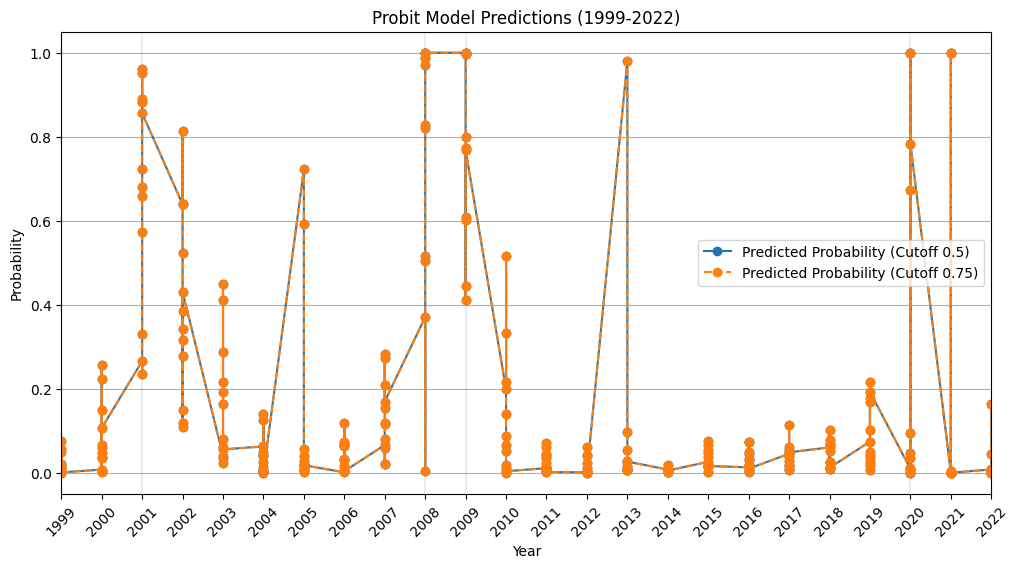

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from scipy.stats import norm

beta_strt = np.full(X.shape[1], 0.5)

def probit_log_likelihood(beta, y, X):
    mu = np.dot(X, beta)
    likelihood = y * np.log(norm.cdf(mu)) + (1 - y) * np.log(1 - norm.cdf(mu))
    return -np.sum(likelihood)

from scipy.optimize import minimize
result = minimize(probit_log_likelihood, beta_strt, args=(y_train, x_train), method='BFGS')
beta_hat = result.x

def probit_predict(beta, X, cutoff=0.5):
    prob = norm.cdf(np.dot(X, beta))
    y_pred = (prob >= cutoff).astype(int)
    return prob, y_pred

y_prob, y_hat_05 = probit_predict(beta_hat, x_test, cutoff=0.5)
y_prob2, y_hat_075 = probit_predict(beta_hat, x_test, cutoff=0.75)

def evaluate_model(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    specificity = tn / (tn + fp)
    balanced_accuracy = (recall + specificity) / 2
    return {
        'Confusion Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Specificity': specificity,
        'Balanced Accuracy': balanced_accuracy
    }

print("Evaluation for Cutoff 0.5:")
metrics_05 = evaluate_model(y_test, y_hat_05)
for metric, value in metrics_05.items():
    print(f"{metric}: {value}")

print("\nEvaluation for Cutoff 0.75:")
metrics_075 = evaluate_model(y_test, y_hat_075)
for metric, value in metrics_075.items():
    print(f"{metric}: {value}")

plt.figure(figsize=(12, 6))
plt.plot(date_test.dt.year, y_prob, label='Predicted Probability (Cutoff 0.5)', marker='o')
plt.plot(date_test.dt.year, y_prob2, label='Predicted Probability (Cutoff 0.75)', linestyle='--', marker='o')
plt.ylabel('Probability')
plt.xlabel('Year')
plt.title('Probit Model Predictions (1999-2022)')
plt.xticks(date_test.dt.year.unique(), rotation=45)
plt.xlim([1999, 2022])
plt.grid(True, axis='y')
plt.legend()

recession_years = dates[data['USREC'] == 1].dt.year.unique()
for rec_year in recession_years:
    if 1999 <= rec_year <= 2022:
        plt.axvline(x=rec_year, color='gray', alpha=0.15)

plt.show()


In [ ]:
from sklearn.neighbors import KNeighborsClassifier


k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(x_train, y_train)

y_hat = knn_model.predict(x_test)

print("KNN Model Evaluation")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_hat))
print("\nClassification Report:\n", classification_report(y_test, y_hat))

accuracy = accuracy_score(y_test, y_hat)
precision = precision_score(y_test, y_hat, zero_division=0)
recall = recall_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat)

tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
specificity = tn / (tn + fp)
balanced_accuracy = (recall + specificity) / 2

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Specificity: {specificity}")
print(f"Balanced Accuracy: {balanced_accuracy}")


KNN Model Evaluation
Confusion Matrix:
 [[257   3]
 [  8  20]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       260
         1.0       0.87      0.71      0.78        28

    accuracy                           0.96       288
   macro avg       0.92      0.85      0.88       288
weighted avg       0.96      0.96      0.96       288

Accuracy: 0.9618055555555556
Precision: 0.8695652173913043
Recall: 0.7142857142857143
F1-Score: 0.7843137254901961
Specificity: 0.9884615384615385
Balanced Accuracy: 0.8513736263736265


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


# param_grid = {
#     'n_estimators': [50, 100, 150, 200],
#     'max_depth': [None, 5, 10, 15, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None]
# }

# rf_model = RandomForestClassifier(random_state=42)

# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(x_train, y_train)

# best_rf_model = grid_search.best_estimator_
# print("Best Parameters:", grid_search.best_params_)
# y_hat = best_rf_model.predict(x_test)

# Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, max_features = 'sqrt', min_samples_leaf = 4, min_samples_split = 2)
rf_model.fit(x_train, y_train)

y_hat = rf_model.predict(x_test)

print("\nDecision Forest (Random Forest) Model Evaluation with Optimized Parameters")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_hat))
print("\nClassification Report:\n", classification_report(y_test, y_hat))

accuracy = accuracy_score(y_test, y_hat)
precision = precision_score(y_test, y_hat, zero_division=0)
recall = recall_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat)

tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
specificity = tn / (tn + fp)
balanced_accuracy = (recall + specificity) / 2

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Specificity: {specificity}")
print(f"Balanced Accuracy: {balanced_accuracy}")



Decision Forest (Random Forest) Model Evaluation with Optimized Parameters
Confusion Matrix:
 [[257   3]
 [  3  25]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       260
         1.0       0.89      0.89      0.89        28

    accuracy                           0.98       288
   macro avg       0.94      0.94      0.94       288
weighted avg       0.98      0.98      0.98       288

Accuracy: 0.9791666666666666
Precision: 0.8928571428571429
Recall: 0.8928571428571429
F1-Score: 0.8928571428571429
Specificity: 0.9884615384615385
Balanced Accuracy: 0.9406593406593406
